In [1]:
# Covers tabular implementations of SERD and IDL and compares their effectivenes

In [1]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [2]:
# %store -r

In [3]:
#%store

In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"resources/rover_left.png",
        RIGHT:"resources/rover_right.png",
        DOWN:"resources/rover_down.png",
        UP:"resources/rover_up.png",
        NOOP:"resources/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]


# tile_map = [
#         "2FFFUFFF1",
#         "FFFUUUFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_map = [
  "SFFFUFFFSFUUFFU",
  "F1F2FSF2SFFFFFF",
  "FFFUFF1FFF2FUUF",
  "UUFFFFSFFFUSFFF",
  "FFSFFSFUFFUSFFF",
  "SFU2UUFFFFUFFFU",
  "FSFFFFSFF2FF1FU",
  "FFFFFFSUFSFFFFF",
  "FFUFFSFFFFFUFFS",
  "2FFFFSFFF1SFFUF",
  "1UFU3UFFFUFFFFF",
  "F3FUSFFFFFFFFFF",
  "F1FFFFFFUFFF3UF",
  "F1FSSFFFFUSFUUF",
  "FFFFFFFUFFFSF2F",
]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.0,
              '1':0.0,
              '2':0.0,
              '3':0.0,
              'S':0.0,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':0.125,
              '2':0.25,
              '3':1.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.6,0.2,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.99

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [5]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [6]:
# temperature = 1/(reward_normalizer)
# print(temperature)

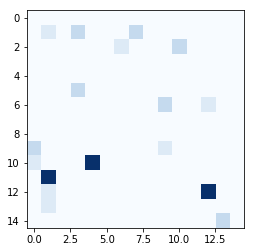

In [7]:
plt.imshow(reward_map, cmap="Blues")

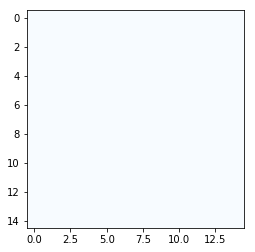

In [8]:
plt.imshow(texture_map, cmap="Blues")

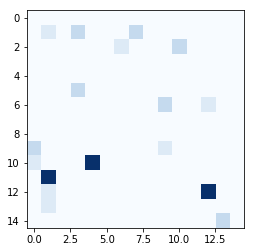

In [9]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [10]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

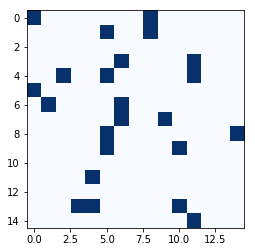

In [11]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [12]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [13]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [14]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [15]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=50):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=50):
    softQs = softmax(Qs * beta)
    return softQs


In [16]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [17]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    print(Tps)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad)

In [18]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


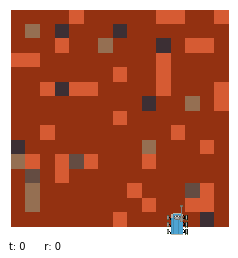

[65.2349839  30.15246967 59.1010615  80.9943244  80.18438115]
3
[0.0000001  0.         0.         0.69209734 0.30790256]
(11, 14) b'S'
(12, 14) b'F'


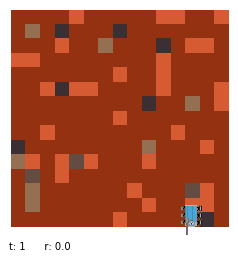

[61.64573532 70.95522427 56.50287131 30.36902452 70.24567203]
1
[0.0000607  0.67026129 0.00000035 0.         0.32967766]
(12, 14) b'F'
(12, 0) b'F'


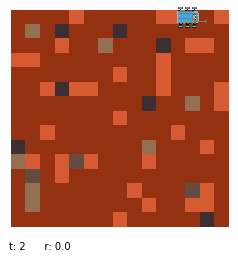

[27.51246465 53.97787236 68.34302999 55.76396504 67.65959969]
2
[0.         0.00000038 0.6645021  0.00000229 0.33549523]
(12, 0) b'F'
(13, 0) b'F'


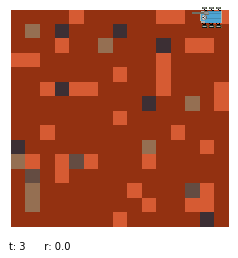

[68.75441987 55.04332212 28.16822012 56.50287131 68.06687567]
0
[0.66541779 0.00000074 0.         0.00000318 0.33457829]
(13, 0) b'F'
(13, 14) b'2'


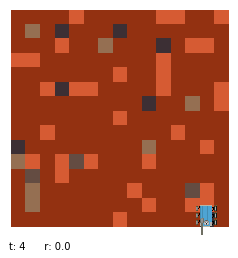

[55.76396504 72.08377893 65.20011918 31.25321358 71.61294114]
1
[0.00000005 0.61519406 0.0006302  0.         0.38417569]
(13, 14) b'2'
(13, 0) b'F'


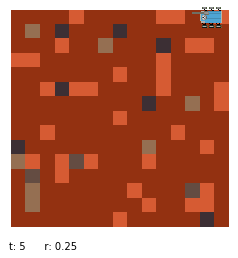

[68.75441987 55.04332212 28.16822012 56.50287131 68.06687567]
0
[0.66541779 0.00000074 0.         0.00000318 0.33457829]
(13, 0) b'F'
(13, 14) b'2'


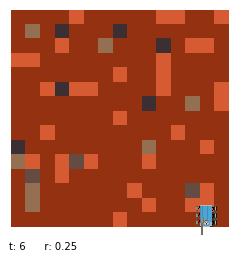

[55.76396504 72.08377893 65.20011918 31.25321358 71.61294114]
1
[0.00000005 0.61519406 0.0006302  0.         0.38417569]
(13, 14) b'2'
(13, 0) b'F'


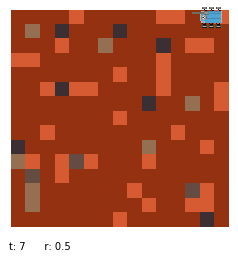

[68.75441987 55.04332212 28.16822012 56.50287131 68.06687567]
0
[0.66541779 0.00000074 0.         0.00000318 0.33457829]
(13, 0) b'F'
(12, 0) b'F'


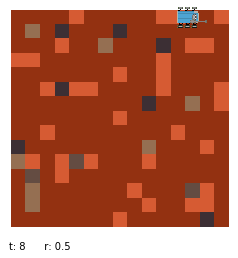

[27.51246465 53.97787236 68.34302999 55.76396504 67.65959969]
2
[0.         0.00000038 0.6645021  0.00000229 0.33549523]
(12, 0) b'F'
(13, 0) b'F'


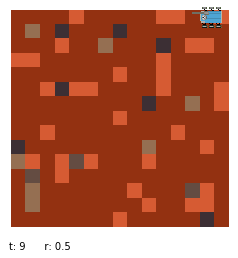

[68.75441987 55.04332212 28.16822012 56.50287131 68.06687567]
0
[0.66541779 0.00000074 0.         0.00000318 0.33457829]
(13, 0) b'F'
(13, 1) b'F'


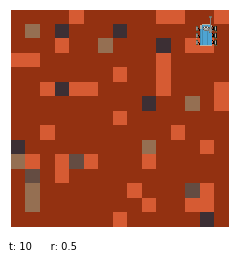

[53.97787236 29.04858532 60.37232705 69.87915066 69.18035915]
3
[0.00000008 0.         0.00004965 0.66788656 0.3320637 ]
(13, 1) b'F'
(13, 0) b'F'


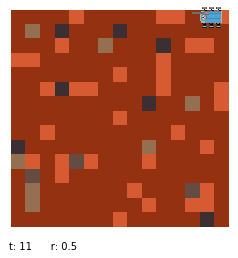

[68.75441987 55.04332212 28.16822012 56.50287131 68.06687567]
0
[0.66541779 0.00000074 0.         0.00000318 0.33457829]
(13, 0) b'F'
(13, 14) b'2'


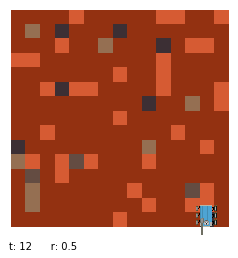

[55.76396504 72.08377893 65.20011918 31.25321358 71.61294114]
1
[0.00000005 0.61519406 0.0006302  0.         0.38417569]
(13, 14) b'2'
(14, 14) b'F'


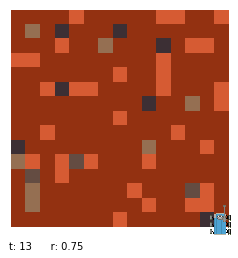

[61.10923882 32.43570336 72.45213936 86.84100565 85.97259559]
3
[0.         0.         0.0000004  0.70441448 0.29558513]
(14, 14) b'F'
(0, 14) b'F'


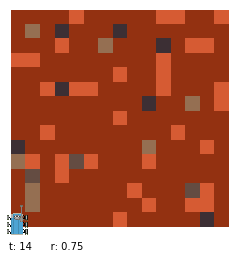

[87.84599262 88.5416056  91.43209634 91.41451248 90.51777537]
3
[0.01123243 0.02252033 0.40541414 0.3983477  0.1624854 ]
(0, 14) b'F'
(0, 13) b'F'


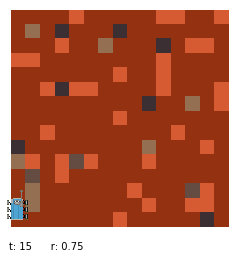

[91.51154102 91.32137243 93.71393795 93.99007802 93.05017724]
3
[0.03642253 0.03011487 0.3295027  0.43429525 0.16966465]
(0, 13) b'F'
(14, 13) b'F'


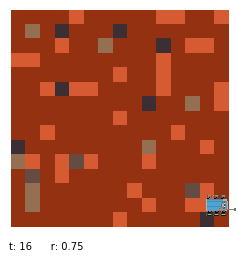

[35.78696608 70.19677949 91.60751236 74.36188284 90.69143724]
2
[0.         0.         0.71424169 0.00000002 0.28575828]
(14, 13) b'F'
(0, 13) b'F'


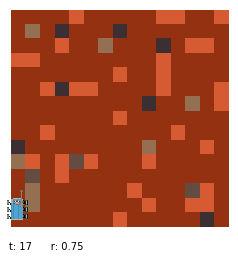

[91.51154102 91.32137243 93.71393795 93.99007802 93.05017724]
3
[0.03642253 0.03011487 0.3295027  0.43429525 0.16966465]
(0, 13) b'F'
(14, 13) b'F'


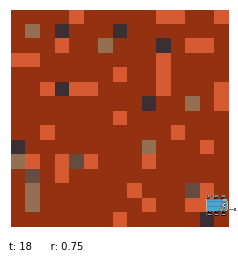

[35.78696608 70.19677949 91.60751236 74.36188284 90.69143724]
2
[0.         0.         0.71424169 0.00000002 0.28575828]
(14, 13) b'F'
(14, 14) b'F'


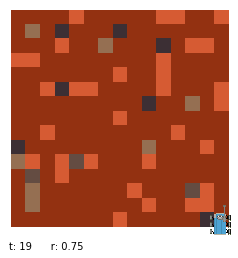

[61.10923882 32.43570336 72.45213936 86.84100565 85.97259559]
3
[0.         0.         0.0000004  0.70441448 0.29558513]
(14, 14) b'F'
(14, 13) b'F'


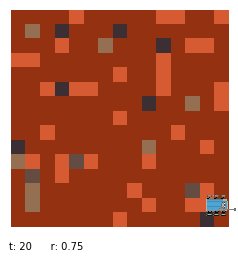

[35.78696608 70.19677949 91.60751236 74.36188284 90.69143724]
2
[0.         0.         0.71424169 0.00000002 0.28575828]
(14, 13) b'F'
(0, 13) b'F'


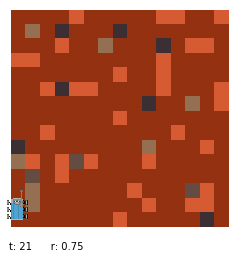

[91.51154102 91.32137243 93.71393795 93.99007802 93.05017724]
3
[0.03642253 0.03011487 0.3295027  0.43429525 0.16966465]
(0, 13) b'F'
(1, 13) b'1'


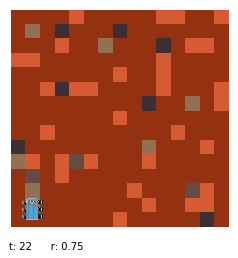

[93.57979551 92.27924331 93.24832953 95.18898867 94.36209878]
3
[0.10898552 0.02968562 0.0782375  0.54479424 0.23829712]
(1, 13) b'1'
(0, 13) b'F'


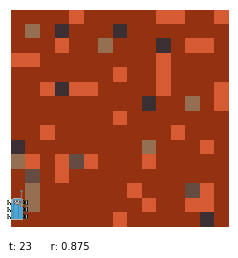

[91.51154102 91.32137243 93.71393795 93.99007802 93.05017724]
3
[0.03642253 0.03011487 0.3295027  0.43429525 0.16966465]
(0, 13) b'F'
(1, 13) b'1'


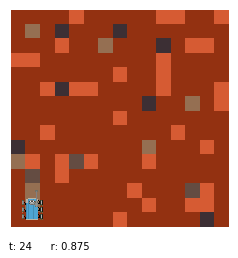

[93.57979551 92.27924331 93.24832953 95.18898867 94.36209878]
3
[0.10898552 0.02968562 0.0782375  0.54479424 0.23829712]
(1, 13) b'1'
(2, 13) b'F'


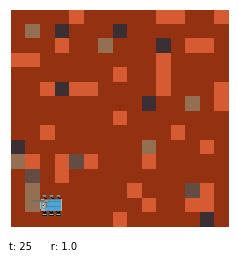

[93.43205449 91.40711764 91.00226239 92.90708564 92.49773395]
0
[0.45362093 0.05987895 0.03994365 0.26835025 0.17820621]
(2, 13) b'F'
(1, 13) b'1'


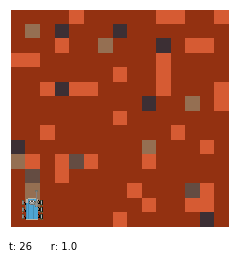

[93.57979551 92.27924331 93.24832953 95.18898867 94.36209878]
3
[0.10898552 0.02968562 0.0782375  0.54479424 0.23829712]
(1, 13) b'1'
(1, 12) b'1'


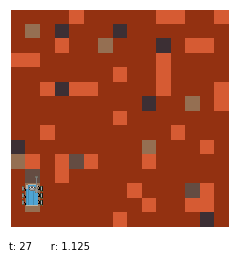

[95.85179057 94.26777515 94.84459659 97.65051588 96.79901072]
3
[0.0981271  0.02013074 0.03584018 0.59287814 0.25302384]
(1, 12) b'1'
(1, 11) b'3'


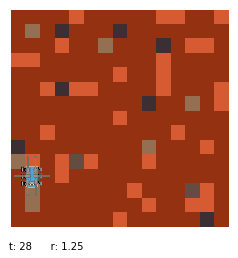

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


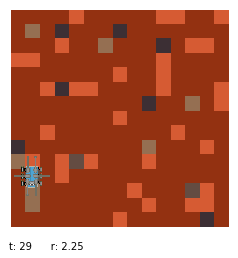

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


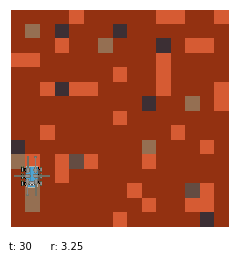

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


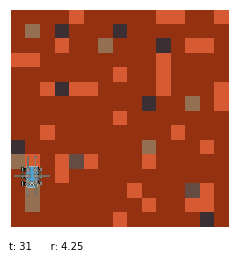

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


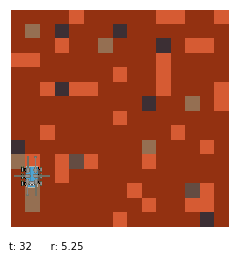

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


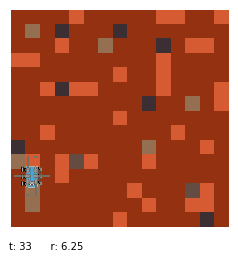

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


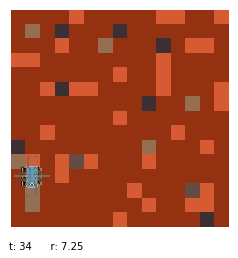

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


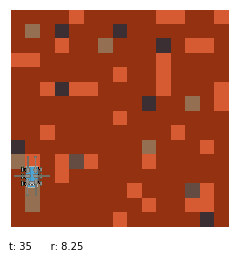

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


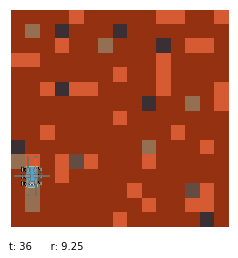

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


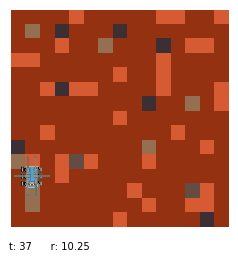

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


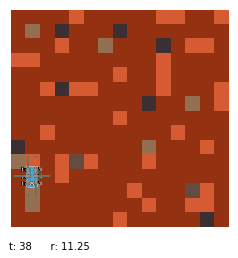

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


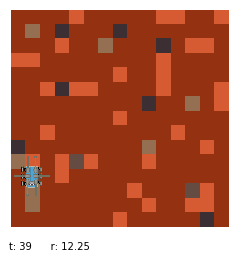

[ 77.06926326  94.96513194  72.31389093  36.89528557 100.        ]
4
[0.         0.00646499 0.         0.         0.99353501]
(1, 11) b'3'
(1, 11) b'3'


In [19]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q),Qs=Q)


In [20]:
# print(mdp.feature_map)

# Inverse Dynamics Learning

In [21]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [22]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s])[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [23]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose,
                      ftol=tabsoftq_iter_ftol)
    print(np.max(Q), np.min(Q))
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [24]:
def tabsoftq_TR_grad_iter(T_thetas, feat_map, R,  Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = feat_map.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    R_grad = T.dot(feat_map)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_t = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_t = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_t = R_t + gamma * V_t 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_t)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad), (GT - expGT_broad)

In [25]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, feat_map, R, Q, T=T,
        maxiter=tabsoftq_grad_iter_maxiter, verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(feat_map.shape[1]) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [40]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 80
demo_time_steps = 40

In [27]:
# def clean_demos(sas_obs):
#     demo_example_idxes = list(range(len(sas_obs)))
#     unique_stays = set([])
#     for i,sas in enumerate(sas_obs):
#         sas = tuple(sas)
#         if sas[1] == 4:
#             if sas in unique_stays:
#                 demo_example_idxes.remove(i)
#             else:
#                 unique_stays.add(sas)
#     return demo_example_idxes

def clean_demos(sas_obs, adt_obs, max_noops=50):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,(sas,adt) in enumerate(zip(sas_obs,adt_obs)):
        sas = tuple(sas)
        if adt[2] == 1:
            demo_example_idxes.remove(i)
            continue
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if max_noops and stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0

    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [28]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/nA

In [29]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [30]:
# Ensure bad areas have not been visited in exes
# while len(set([adt[2] for adt in adt_obs])) > 1:
#     demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
#     sas_obs, adt_obs = vectorize_rollouts(demos)

In [31]:
# Clean training set to have greater density of interesting transitions
print(len(sas_obs))
demo_example_idxes = clean_demos(sas_obs, adt_obs)
print(len(demo_example_idxes))
# demo_example_idxes = list(range(len(sas_obs)))


3200
3200


In [32]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [49]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [38]:
maxiter = 2000
learning_rate = 2.0

In [39]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [40]:

while len(idl_train_logs['tt_lls']) < maxiter:
    try:
        batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
        #Should we initialize Qs or nah?
        tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi, verbose=False)
        tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
        train_likelihood = tp_ll + tt_ll
        vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
        val_likelihood = vp_ll + vt_ll
        ttd = true_trans_loss(softmax(Ti_thetas))
        Ti_thetas += learning_rate * dT_pol #(dT_trans + dT_pol)
        
#         print(np.max(dT_pol),np.min(dT_pol))


        print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), -vp_ll, -vt_ll, -vp_ll - vt_ll, ttd))
        idl_train_logs['train_likelihoods'].append(train_likelihood)
        idl_train_logs['val_likelihoods'].append(val_likelihood)
        idl_train_logs['tp_lls'].append(-tp_ll)
        idl_train_logs['tt_lls'].append(-tt_ll)
        idl_train_logs['vp_lls'].append(-vp_ll)
        idl_train_logs['vt_lls'].append(-vt_ll)
        idl_train_logs['true_trans_loss'].append(ttd)
    except KeyboardInterrupt:
        break

99.99996966124785 71.91438123705242
[[[0.54782594 0.2       ]
  [0.2        0.2       ]
  [0.00000009 0.2       ]
  [0.25217389 0.2       ]
  [0.00000009 0.2       ]]

 [[0.24456521 0.2       ]
  [0.58695642 0.2       ]
  [0.16847827 0.2       ]
  [0.00000005 0.2       ]
  [0.00000005 0.2       ]]

 [[0.00000005 0.2       ]
  [0.22950819 0.2       ]
  [0.61202175 0.2       ]
  [0.15846996 0.2       ]
  [0.00000005 0.2       ]]

 [[0.15602838 0.2       ]
  [0.00000007 0.2       ]
  [0.14184399 0.2       ]
  [0.70212748 0.2       ]
  [0.00000007 0.2       ]]

 [[0.         0.2       ]
  [0.         0.2       ]
  [0.         0.2       ]
  [0.         0.2       ]
  [0.99999998 0.2       ]]]
0 610.713575 56.393397 667.106972 1.621853
99.9999696113014 71.81933702760526
[[[0.54275625 0.19897107]
  [0.20182672 0.20022321]
  [0.00000009 0.20091595]
  [0.25541685 0.19967036]
  [0.00000009 0.2002194 ]]

 [[0.24550825 0.19897107]
  [0.58544869 0.20022321]
  [0.16904295 0.20091595]
  [0.00000005 0.

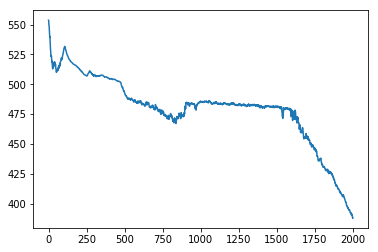

In [38]:
plt.plot(idl_train_logs['vp_lls'])

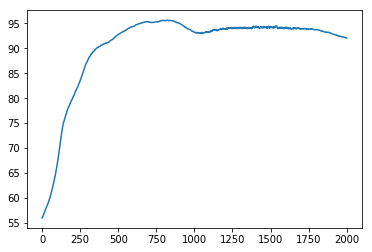

In [39]:
plt.plot(idl_train_logs['vt_lls'])

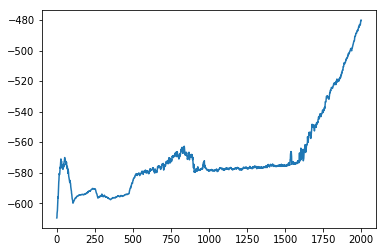

In [40]:
plt.plot(idl_train_logs['val_likelihoods'])

In [41]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[53.3273598  53.3273598  53.3273598  53.3273598  53.3273598 ]
 [58.9336244  58.9336244  58.9336244  58.9336244  58.9336244 ]
 [56.52862372 56.52862372 56.52862372 56.52862372 56.52862372]
 [53.8158799  53.8158799  53.8158799  53.8158799  53.8158799 ]
 [63.82954524 63.82954524 63.82954524 63.82954524 63.82954524]
 [67.16846281 67.16846281 67.16846281 67.16846281 67.16846281]
 [75.96110415 75.96110415 75.96110415 75.96110415 75.96110415]
 [58.25172408 58.25172408 58.25172408 58.25172408 58.25172408]
 [60.10547176 60.10547176 60.10547176 60.10547176 60.10547176]
 [69.60420706 69.60420706 69.60420706 69.60420706 69.60420706]
 [59.65463691 59.65463691 59.65463691 59.65463691 59.65463691]
 [53.12522117 53.12522117 53.12522117 53.12522117 53.12522117]
 [56.18359566 56.18359566 56.18359566 56.18359566 56.18359566]
 [57.22930982 57.22930982 57.22930982 57.22930982 57.22930982]
 [52.61090658 52.61090658 52.61090658 52.61090658 52.61090658]
 [51.71430645 51.71430645 51.71430645 51.71430645 51.71

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


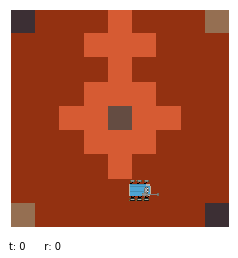

(5, 7) b'S'
(6, 7) b'F'


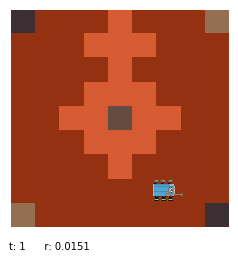

(6, 7) b'F'
(6, 6) b'F'


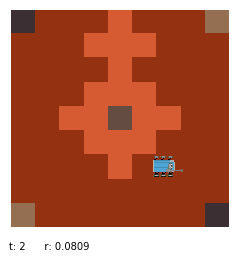

(6, 6) b'F'
(7, 6) b'F'


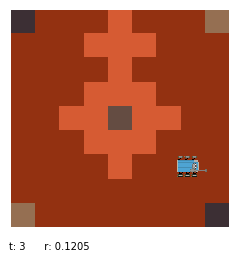

(7, 6) b'F'
(7, 7) b'F'


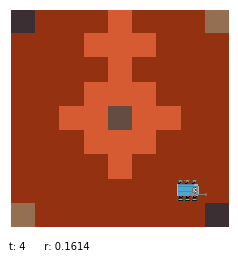

(7, 7) b'F'
(7, 6) b'F'


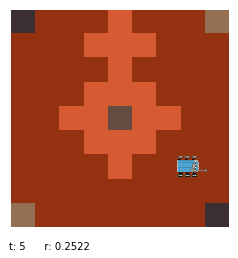

(7, 6) b'F'
(8, 6) b'F'


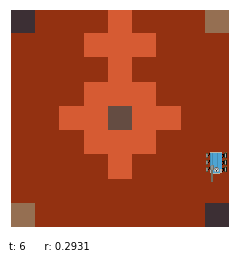

(8, 6) b'F'
(0, 6) b'F'


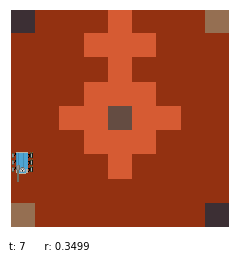

(0, 6) b'F'
(1, 6) b'F'


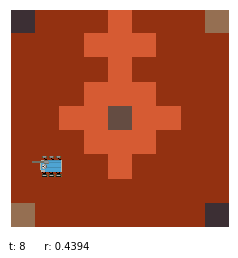

(1, 6) b'F'
(1, 5) b'S'


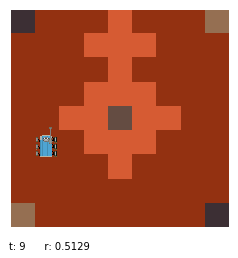

(1, 5) b'S'
(1, 4) b'S'


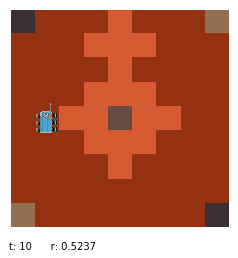

(1, 4) b'S'
(1, 3) b'S'


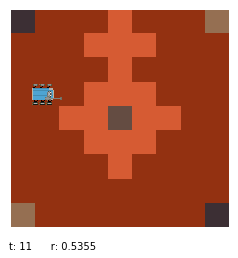

(1, 3) b'S'
(1, 2) b'F'


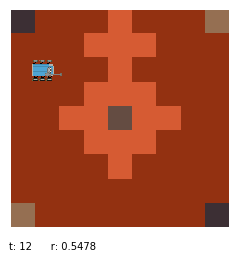

(1, 2) b'F'
(2, 2) b'F'


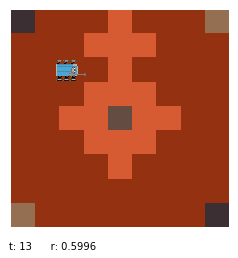

(2, 2) b'F'
(3, 2) b'F'


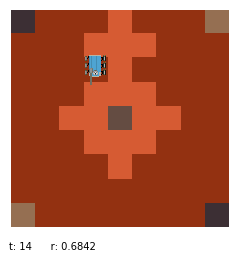

(3, 2) b'F'
(2, 2) b'F'


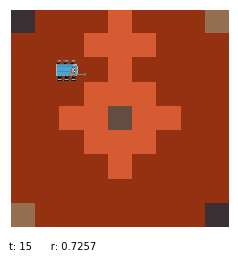

(2, 2) b'F'
(3, 2) b'F'


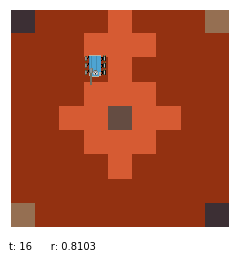

(3, 2) b'F'
(3, 3) b'U'


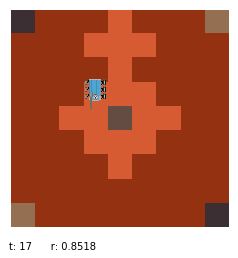

(3, 3) b'U'
(3, 3) b'U'


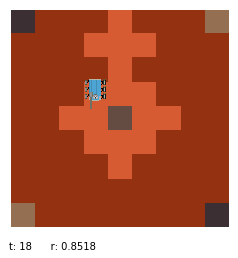

(3, 3) b'U'
(3, 3) b'U'


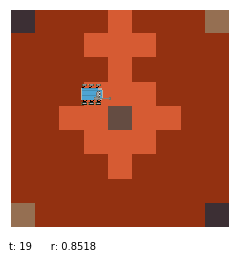

(3, 3) b'U'
(3, 3) b'U'


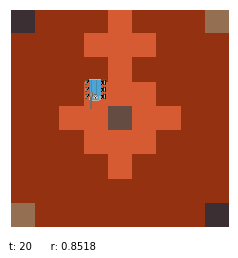

(3, 3) b'U'
(3, 3) b'U'


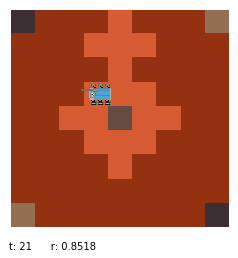

(3, 3) b'U'
(3, 3) b'U'


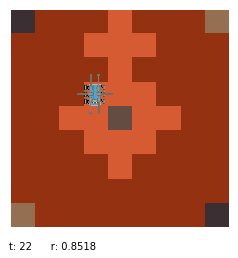

(3, 3) b'U'
(3, 3) b'U'


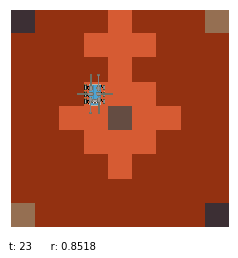

(3, 3) b'U'
(3, 3) b'U'


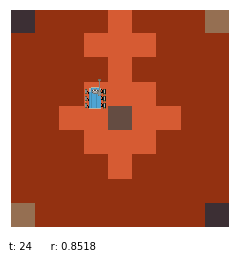

(3, 3) b'U'
(3, 3) b'U'


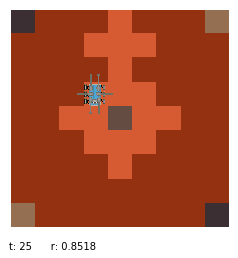

(3, 3) b'U'
(3, 3) b'U'


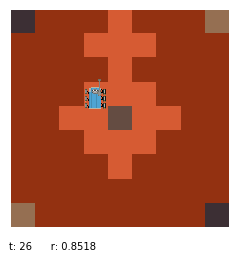

(3, 3) b'U'
(3, 3) b'U'


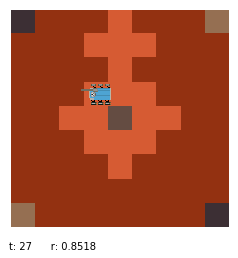

(3, 3) b'U'
(3, 3) b'U'


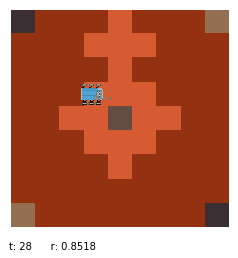

(3, 3) b'U'
(3, 3) b'U'


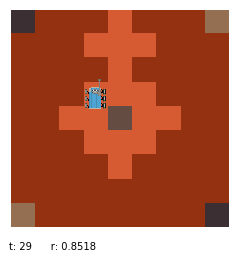

(3, 3) b'U'
(3, 3) b'U'


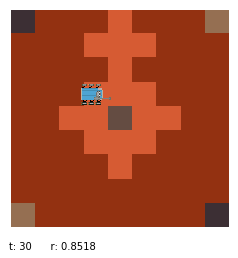

(3, 3) b'U'
(3, 3) b'U'


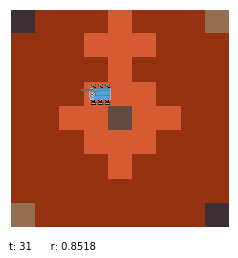

(3, 3) b'U'
(3, 3) b'U'


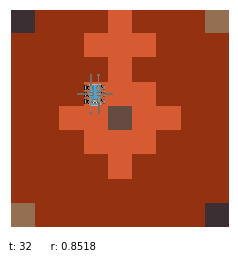

(3, 3) b'U'
(3, 3) b'U'


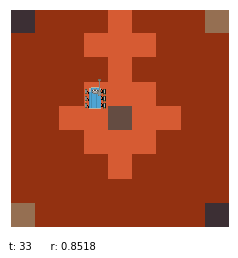

(3, 3) b'U'
(3, 3) b'U'


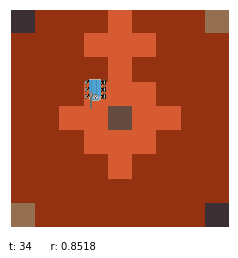

(3, 3) b'U'
(3, 3) b'U'


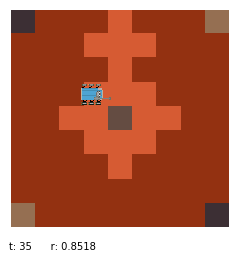

(3, 3) b'U'
(3, 3) b'U'


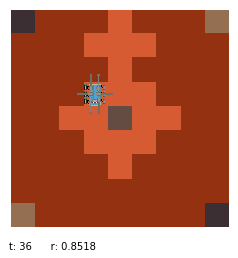

(3, 3) b'U'
(3, 3) b'U'


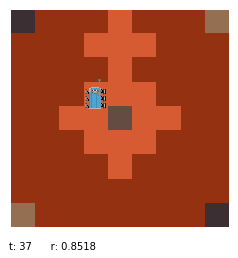

(3, 3) b'U'
(3, 3) b'U'


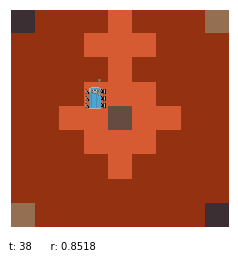

(3, 3) b'U'
(3, 3) b'U'


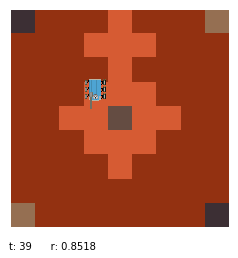

(3, 3) b'U'
(3, 3) b'U'
[[[0.02406396 0.04390975]
  [0.64733023 0.10766697]
  [0.00000005 0.07844411]
  [0.32860572 0.03422939]
  [0.00000005 0.73574976]]

 [[0.06425945 0.04390975]
  [0.78405152 0.10766697]
  [0.15168898 0.07844411]
  [0.00000003 0.03422939]
  [0.00000003 0.73574976]]

 [[0.00000005 0.04390975]
  [0.4657699  0.10766697]
  [0.27425712 0.07844411]
  [0.25997289 0.03422939]
  [0.00000005 0.73574976]]

 [[0.09388688 0.04390975]
  [0.00000006 0.10766697]
  [0.13348572 0.07844411]
  [0.77262728 0.03422939]
  [0.00000006 0.73574976]]

 [[0.         0.04390975]
  [0.         0.10766697]
  [0.         0.07844411]
  [0.         0.03422939]
  [0.99999998 0.73574976]]]


In [42]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [43]:
Qi.shape

(81, 5)

In [44]:
softmax(Ti_thetas).transpose((2,0,1))

array([[[0.02406396, 0.64733023, 0.00000005, 0.32860572, 0.00000005],
        [0.06425945, 0.78405152, 0.15168898, 0.00000003, 0.00000003],
        [0.00000005, 0.4657699 , 0.27425712, 0.25997289, 0.00000005],
        [0.09388688, 0.00000006, 0.13348572, 0.77262728, 0.00000006],
        [0.        , 0.        , 0.        , 0.        , 0.99999998]],

       [[0.04390975, 0.10766697, 0.07844411, 0.03422939, 0.73574976],
        [0.04390975, 0.10766697, 0.07844411, 0.03422939, 0.73574976],
        [0.04390975, 0.10766697, 0.07844411, 0.03422939, 0.73574976],
        [0.04390975, 0.10766697, 0.07844411, 0.03422939, 0.73574976],
        [0.04390975, 0.10766697, 0.07844411, 0.03422939, 0.73574976]]])

In [45]:
tabsoftq_gen_pol_probs(Qi)

array([[0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.00000008, 0.99951537, 0.00048455, 0.        , 0.        ],
       [0.00177775, 0.99822225, 0.        , 0.        , 0.        ],
       [0.88346605, 0.11653395, 0.        , 0.        , 0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.00000021, 0.94935097, 0.05064882, 0.        , 0.        ],
       [0.        , 0.00000001, 0.99998612, 0.00001387, 0.        ],
       [0.        , 0.        , 0.99989357, 0.00010642, 0.        ],
       [0.        , 0.        , 0.67749767, 0.32229562, 0.00020671],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.01145386, 0.98854614, 0.        , 0.        ],
       [0.00059949, 0.99940051, 0.        , 0.        , 0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.

In [46]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.02406396 0.04390975]
  [0.64733023 0.10766697]
  [0.00000005 0.07844411]
  [0.32860572 0.03422939]
  [0.00000005 0.73574976]]

 [[0.06425945 0.04390975]
  [0.78405152 0.10766697]
  [0.15168898 0.07844411]
  [0.00000003 0.03422939]
  [0.00000003 0.73574976]]

 [[0.00000005 0.04390975]
  [0.4657699  0.10766697]
  [0.27425712 0.07844411]
  [0.25997289 0.03422939]
  [0.00000005 0.73574976]]

 [[0.09388688 0.04390975]
  [0.00000006 0.10766697]
  [0.13348572 0.07844411]
  [0.77262728 0.03422939]
  [0.00000006 0.73574976]]

 [[0.         0.04390975]
  [0.         0.10766697]
  [0.         0.07844411]
  [0.         0.03422939]
  [0.99999998 0.73574976]]]


In [47]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[53.30636702 53.30636702 53.30636702 53.30636702 53.30636702]
 [58.91155465 58.91155465 58.91155465 58.91155465 58.91155465]
 [56.50381723 56.50381723 56.50381723 56.50381723 56.50381723]
 [53.8052581  53.8052581  53.8052581  53.8052581  53.8052581 ]
 [63.80405384 63.80405384 63.80405384 63.80405384 63.80405384]
 [67.15689785 67.15689785 67.15689785 67.15689785 67.15689785]
 [75.93716163 75.93716163 75.93716163 75.93716163 75.93716163]
 [58.24189401 58.24189401 58.24189401 58.24189401 58.24189401]
 [60.10195425 60.10195425 60.10195425 60.10195425 60.10195425]
 [69.60611944 69.60611944 69.60611944 69.60611944 69.60611944]
 [59.6504889  59.6504889  59.6504889  59.6504889  59.6504889 ]
 [53.12433589 53.12433589 53.12433589 53.12433589 53.12433589]
 [56.17494062 56.17494062 56.17494062 56.17494062 56.17494062]
 [57.22417448 57.22417448 57.22417448 57.22417448 57.22417448]
 [52.60941939 52.60941939 52.60941939 52.60941939 52.6

-479.7626623579434

In [48]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[76.16427114 76.16427114 76.16427114 76.16427114 76.16427114]
 [76.70692366 76.70692366 76.70692366 76.70692366 76.70692366]
 [76.21571588 76.21571588 76.21571588 76.21571588 76.21571588]
 [76.45544486 76.45544486 76.45544486 76.45544486 76.45544486]
 [79.38469773 79.38469773 79.38469773 79.38469773 79.38469773]
 [81.93656803 81.93656803 81.93656803 81.93656803 81.93656803]
 [85.51727408 85.51727408 85.51727408 85.51727408 85.51727408]
 [81.67553341 81.67553341 81.67553341 81.67553341 81.67553341]
 [80.53518906 80.53518906 80.53518906 80.53518906 80.53518906]
 [85.97602645 85.97602645 85.97602645 85.97602645 85.97602645]
 [85.74727697 85.74727697 85.74727697 85.74727697 85.74727697]
 [80.07430702 80.07430702 80.07430702 80.07430702 80.07430702]
 [82.38322085 82.38322085 82.38322085 82.38322085 82.38322085]
 [86.09974765 86.09974765 86.09974765 86.09974765 86.09974765]
 [82.1785866  82.1785866  82.1785866  82.1785866  82.1

-609.6662822779339

In [49]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

[4, 12, 13, 14, 22, 30, 31, 32, 38, 39, 41, 42, 48, 49, 50, 58]
[[0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]
 [0.01593344 0.01593344 0.01593344 0.01593344 0.01593344]]
-394.34

-451.558641722024

In [50]:
true_trans_loss(softmax(Ti_thetas))

1.5636639168502067

In [51]:
softmax(Ti_thetas)

array([[[0.02406396, 0.04390975],
        [0.64733023, 0.10766697],
        [0.00000005, 0.07844411],
        [0.32860572, 0.03422939],
        [0.00000005, 0.73574976]],

       [[0.06425945, 0.04390975],
        [0.78405152, 0.10766697],
        [0.15168898, 0.07844411],
        [0.00000003, 0.03422939],
        [0.00000003, 0.73574976]],

       [[0.00000005, 0.04390975],
        [0.4657699 , 0.10766697],
        [0.27425712, 0.07844411],
        [0.25997289, 0.03422939],
        [0.00000005, 0.73574976]],

       [[0.09388688, 0.04390975],
        [0.00000006, 0.10766697],
        [0.13348572, 0.07844411],
        [0.77262728, 0.03422939],
        [0.00000006, 0.73574976]],

       [[0.        , 0.04390975],
        [0.        , 0.10766697],
        [0.        , 0.07844411],
        [0.        , 0.03422939],
        [0.99999998, 0.73574976]]])

In [52]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

1.6162940418767004

In [53]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

array([[[0.55645147, 0.2       ],
        [0.17741936, 0.2       ],
        [0.00000008, 0.2       ],
        [0.26612901, 0.2       ],
        [0.00000008, 0.2       ]],

       [[0.22672064, 0.2       ],
        [0.57894729, 0.2       ],
        [0.19433198, 0.2       ],
        [0.00000004, 0.2       ],
        [0.00000004, 0.2       ]],

       [[0.00000004, 0.2       ],
        [0.21991701, 0.2       ],
        [0.60995842, 0.2       ],
        [0.17012449, 0.2       ],
        [0.00000004, 0.2       ]],

       [[0.13605444, 0.2       ],
        [0.00000007, 0.2       ],
        [0.18367347, 0.2       ],
        [0.68027195, 0.2       ],
        [0.00000007, 0.2       ]],

       [[0.        , 0.2       ],
        [0.        , 0.2       ],
        [0.        , 0.2       ],
        [0.        , 0.2       ],
        [0.99999998, 0.2       ]]])

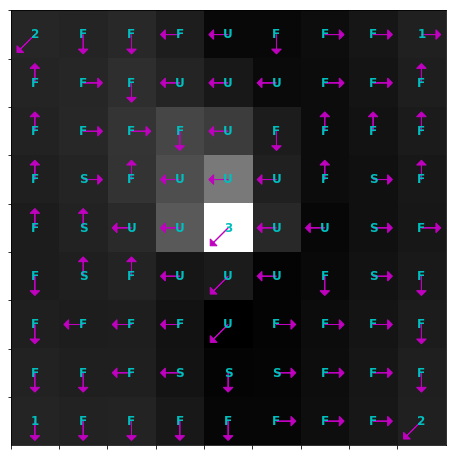

In [54]:
plot_values(mdp, Qi)

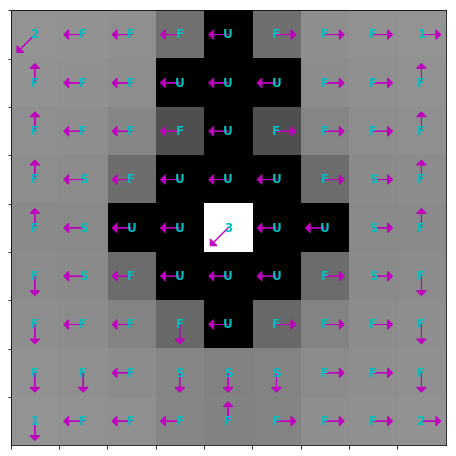

In [55]:
plot_values(mdp, exQs)

## SERD only

In [50]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [51]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [52]:
maxiter = 300
learning_rate = 2.0
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [53]:
%%prun -s cumulative

try:
    while len(serd_train_logs['tt_lls']) < maxiter:
        prevQs = Qs.copy() if Qs is not None else None
        t = len(serd_train_logs['tt_lls'])
        batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
        Rs = feats.dot(Rs_thetas)
        tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
        tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
        train_likelihood = tp_ll + tt_ll
        vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
        val_likelihood = vp_ll + vt_ll
        ttd = true_trans_loss(softmax(Ts_thetas))
        Rs_thetas += learning_rate * dR_pol
        Ts_thetas += learning_rate * (dT_trans + dT_pol)

    #     print(dT_trans)
    #     print(dT_pol)
    #     print(softmax(Ts_thetas))
    #     print(dR_pol * r_learning_rate(t))
    #     print(Rs_thetas)
    #     if prevQs is not None:
    #         print("Q_diff")
    #         print(np.linalg.norm(Qs-prevQs))


        print('%d %f %f %f %f' % (t, -vp_ll, -vt_ll, -vp_ll + -vt_ll, ttd))
        serd_train_logs['train_likelihoods'].append(-train_likelihood)
        serd_train_logs['val_likelihoods'].append(-val_likelihood)
        serd_train_logs['tp_lls'].append(-tp_ll)
        serd_train_logs['tt_lls'].append(-tt_ll)
        serd_train_logs['vp_lls'].append(-vp_ll)
        serd_train_logs['vt_lls'].append(-vt_ll)
        serd_train_logs['true_trans_loss'].append(ttd)
except KeyboardInterrupt:
    pass

0 485.712846 133.625384 619.338230 2.319133
1 162.853480 133.655128 296.508608 2.314842
2 161.293529 133.571041 294.864570 2.315709
3 170.262986 134.572289 304.835274 2.327684
4 438.465059 134.509200 572.974259 2.325609
5 166.581515 134.209391 300.790906 2.313591
6 163.685083 133.206035 296.891118 2.301454
7 162.943302 133.260841 296.204143 2.302224
8 167.425496 133.579688 301.005184 2.308811
9 187.919105 133.581888 321.500993 2.311239
10 254.780474 133.369352 388.149826 2.315122
11 438.956684 133.597996 572.554680 2.316739
12 548.711261 133.746996 682.458257 2.313722
13 206.557595 133.584343 340.141938 2.310915
14 313.353099 134.045356 447.398455 2.303729
15 522.843203 133.540342 656.383546 2.299104
16 187.194332 133.345388 320.539721 2.295243
17 234.817989 133.521526 368.339515 2.298077
18 418.064890 133.551678 551.616568 2.299992
19 514.923117 133.460858 648.383976 2.300700
20 175.846933 133.616189 309.463122 2.304317
21 200.267583 133.981411 334.248994 2.311465
22 270.946775 135.22

181 337.420364 134.553057 471.973421 2.182159
182 513.194870 134.379933 647.574803 2.178796
183 170.783588 133.962782 304.746370 2.173237
184 189.937332 134.631364 324.568697 2.186019
185 248.607437 134.451180 383.058617 2.187100
186 392.291259 134.144718 526.435977 2.180519
187 530.740708 134.211076 664.951785 2.179793
188 181.556387 134.149404 315.705791 2.189507
189 244.127814 135.075791 379.203605 2.204301
190 367.510948 134.786413 502.297361 2.201951
191 534.290145 134.656615 668.946760 2.188985
192 175.120692 134.094368 309.215060 2.175590
193 233.688092 134.582618 368.270710 2.185168
194 376.015428 134.220494 510.235921 2.181637
195 513.083766 134.374222 647.457987 2.183515
196 171.672145 134.074400 305.746545 2.176245
197 199.529042 134.337093 333.866135 2.190218
198 285.679218 134.324954 420.004172 2.199104
199 524.862439 134.481486 659.343925 2.207032
200 182.168722 134.281193 316.449915 2.203859
201 209.554689 134.478941 344.033630 2.204555
 

In [37]:
print(softmax(Ts_thetas))

[[[0.56629209 0.2       ]
  [0.19550562 0.2       ]
  [0.00000002 0.2       ]
  [0.23820224 0.2       ]
  [0.00000002 0.2       ]]

 [[0.20972644 0.2       ]
  [0.60790267 0.2       ]
  [0.18237082 0.2       ]
  [0.00000003 0.2       ]
  [0.00000003 0.2       ]]

 [[0.00000004 0.2       ]
  [0.22314049 0.2       ]
  [0.64049578 0.2       ]
  [0.13636365 0.2       ]
  [0.00000004 0.2       ]]

 [[0.24433249 0.2       ]
  [0.00000003 0.2       ]
  [0.16120907 0.2       ]
  [0.59445839 0.2       ]
  [0.00000003 0.2       ]]

 [[0.00000001 0.2       ]
  [0.00000001 0.2       ]
  [0.00000001 0.2       ]
  [0.00000001 0.2       ]
  [0.99999997 0.2       ]]]


In [61]:
print(Rs_thetas)

[0.49681305 1.13094144 0.74253547]


In [62]:
true_trans_loss(softmax(Ts_thetas))

1.5876990940752809

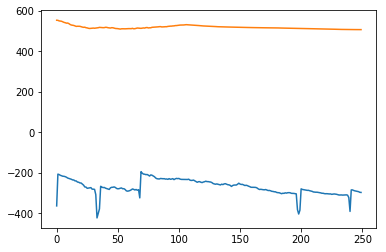

In [63]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

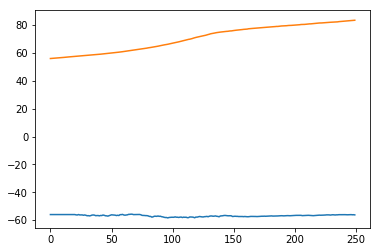

In [64]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

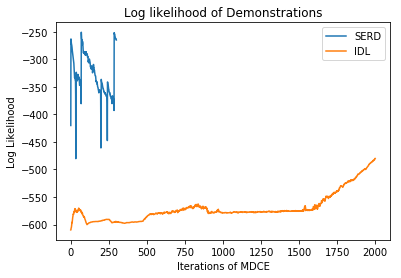

In [65]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

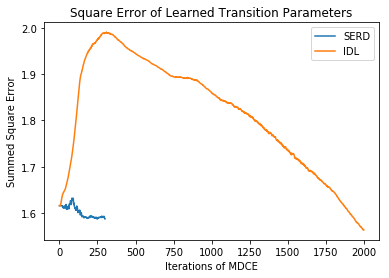

In [66]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [67]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [68]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [69]:
print(demo_stats(mdp, SERD_demos))

{'mean episode reward': 18.763241099824473, 'sd episode reward': 5.273760470073869, 'mean discounted episode reward': 15.099854870443735, 'sd discounted episode reward': 4.307069670485462}


In [70]:
print(demo_stats(mdp, IDL_demos))

{'mean episode reward': 9.028340252019964, 'sd episode reward': 9.7183526849394, 'mean discounted episode reward': 7.321233184060213, 'sd discounted episode reward': 7.812074320921075}


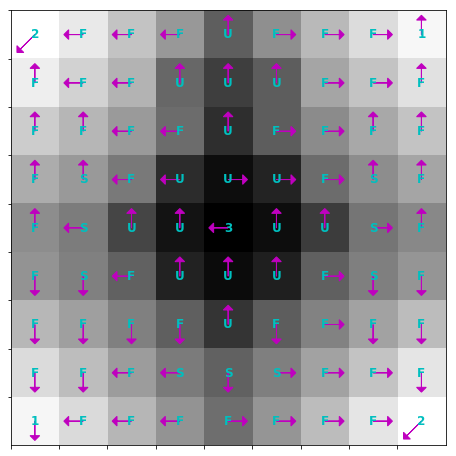

In [71]:
plot_values(mdp, Qs)

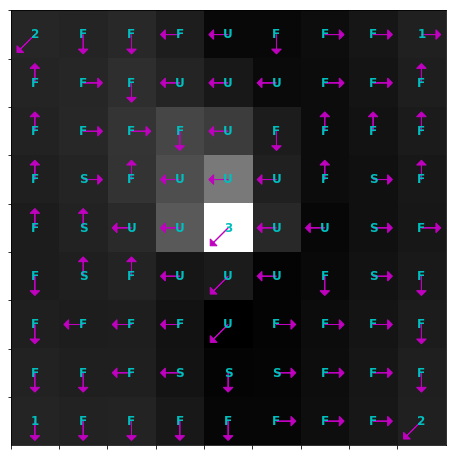

In [72]:
plot_values(mdp, Qi)

In [73]:
print(reward_map[5][0], Qi[2], Q[2])

0.10287197269524406 [59.68486215 59.81147471 58.97751347 58.16444484 59.32237177] [57.49074038 54.16367261 49.26091149 54.61224305 57.02484479]


### Transfer

In [74]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

[[0.67618767 0.14056354 0.1455138  0.08921952 0.09387289 0.08601433
  0.13067641 0.09269368 0.36325799]
 [0.14690395 0.10829713 0.0640705  0.07485574 0.07236237 0.05895493
  0.10529495 0.13188166 0.11331779]
 [0.11401929 0.09694357 0.05040063 0.01930117 0.         0.03713992
  0.03646335 0.08920955 0.09735537]
 [0.11943059 0.03869624 0.05708527 0.         0.         0.
  0.02160595 0.00857146 0.06874117]
 [0.06348109 0.05390636 0.         0.         1.00049655 0.
  0.         0.03172843 0.04190909]
 [0.05916303 0.01426082 0.04966334 0.         0.         0.
  0.00470588 0.00889625 0.06632234]
 [0.11718215 0.01587071 0.04122681 0.03938451 0.         0.01093148
  0.02311856 0.01117571 0.06818466]
 [0.12969489 0.11075986 0.05701639 0.00772544 0.00260944 0.00828445
  0.04802964 0.03853574 0.10752346]
 [0.39673177 0.15698118 0.1345501  0.04635263 0.0419914  0.05033927
  0.08150624 0.10255576 0.50944191]]
[[0.42618767 0.14056354 0.1455138  0.08921952 0.09387289 0.08601433
  0.13067641 0.0926

In [75]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

In [76]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [77]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [78]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [79]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


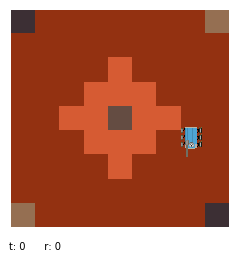

[61.50299462 61.8651889  61.89607038 61.04179834 61.28600592]
1
[0.1867945  0.26832619 0.27674178 0.11777933 0.15035819]
(7, 5) b'S'
(8, 5) b'F'


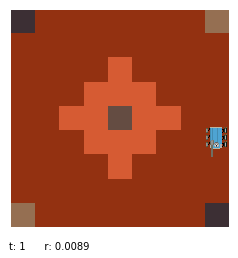

[63.16841625 63.42261873 63.11590039 62.26992621 62.85471487]
1
[0.2285091  0.29464714 0.21681841 0.09304525 0.1669801 ]
(8, 5) b'F'
(8, 6) b'F'


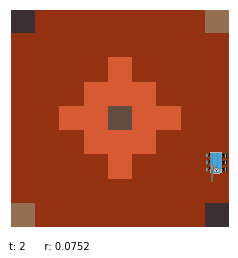

[63.91564947 64.26659342 63.92672974 62.90456201 63.69211215]
1
[0.21762512 0.3091164  0.22004987 0.07917705 0.17403155]
(8, 6) b'F'
(8, 7) b'F'


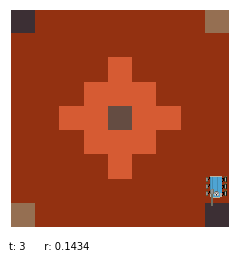

[64.69003005 65.07333355 64.82257026 63.76561028 64.53012367]
1
[0.20585309 0.30201185 0.23502761 0.08167459 0.17543286]
(8, 7) b'F'
(7, 7) b'F'


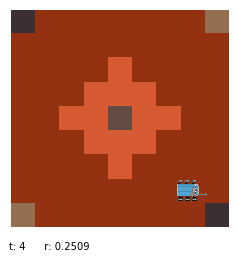

[62.44658033 62.91798505 63.0403618  62.08771621 62.44849393]
2
[0.16357373 0.26208492 0.29620309 0.11425122 0.16388705]
(7, 7) b'F'
(7, 8) b'F'


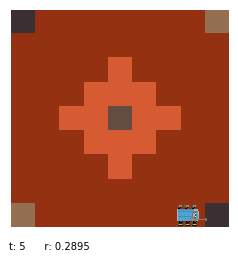

[62.57099813 62.96132082 63.34525714 62.6525192  62.81436032]
2
[0.14271629 0.21085726 0.3095494  0.15483806 0.18203899]
(7, 8) b'F'
(8, 8) b'2'


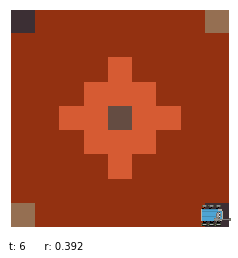

[64.99282251 65.32453751 65.42473805 64.62796178 65.27993257]
2
[0.16777327 0.23376784 0.25840524 0.11648387 0.22356978]
(8, 8) b'2'
(8, 7) b'F'


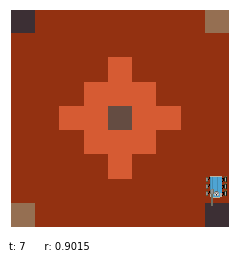

[64.69003005 65.07333355 64.82257026 63.76561028 64.53012367]
1
[0.20585309 0.30201185 0.23502761 0.08167459 0.17543286]
(8, 7) b'F'
(0, 7) b'F'


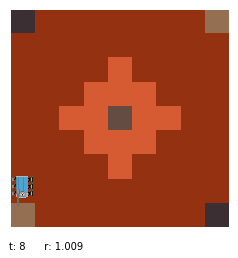

[65.58467499 65.64416067 64.53897985 63.69932149 65.11741393]
1
[0.31335881 0.33256475 0.11012915 0.04756016 0.19638713]
(0, 7) b'F'
(0, 8) b'1'


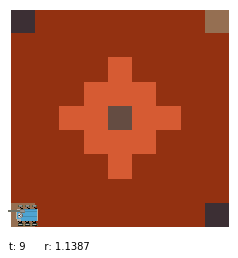

[66.740523   66.64641739 65.4821892  64.74316354 66.46984951]
0
[0.32332405 0.29428522 0.09186511 0.04387285 0.24665277]
(0, 8) b'1'
(0, 0) b'2'


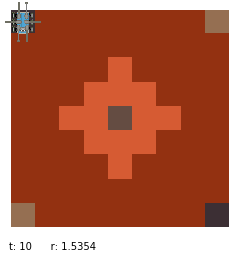

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


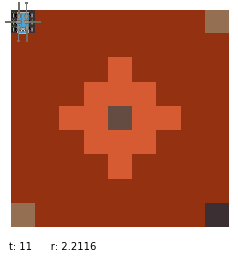

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


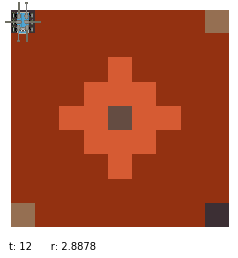

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


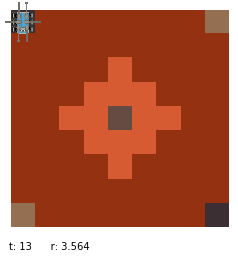

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


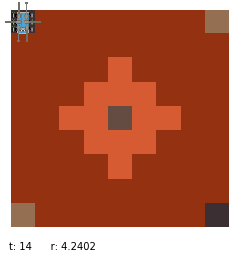

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


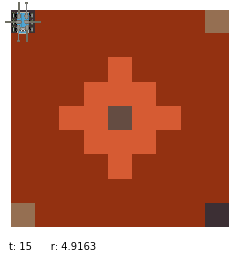

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


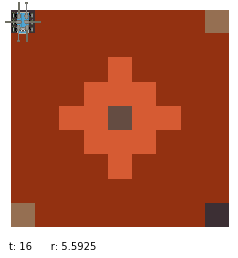

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


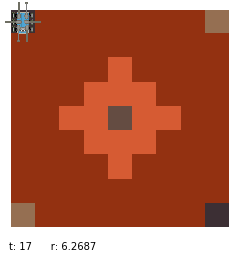

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


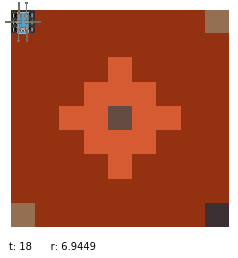

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


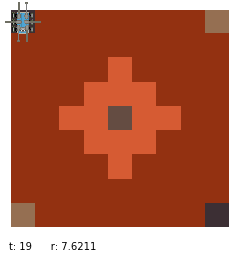

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


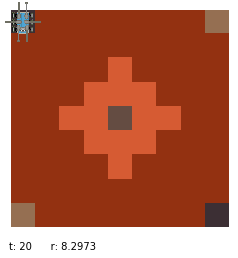

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


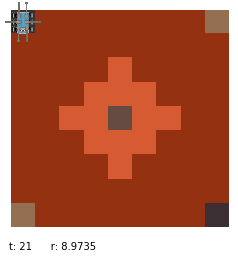

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


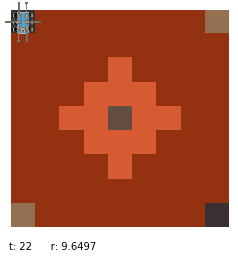

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


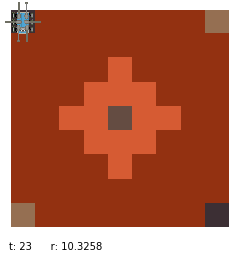

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


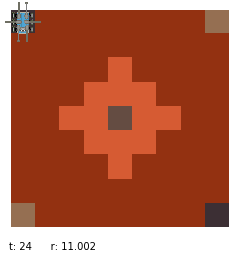

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


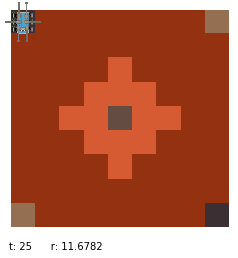

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


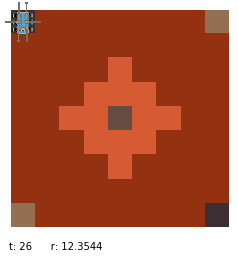

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


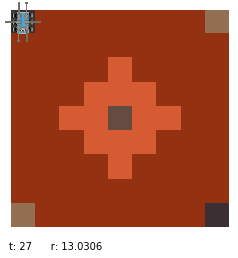

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


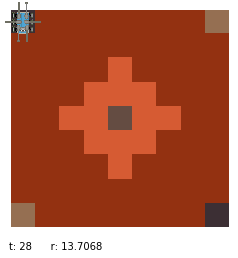

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


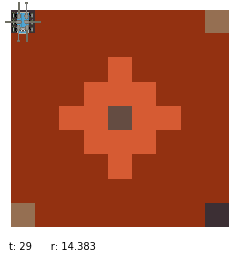

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


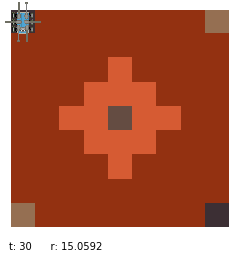

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


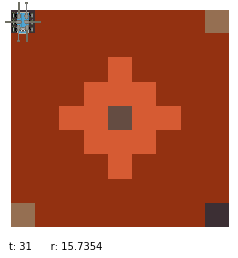

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


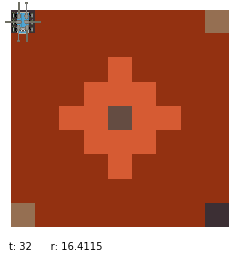

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


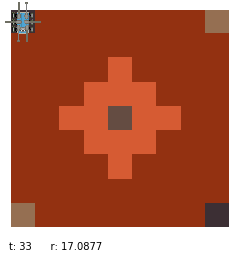

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


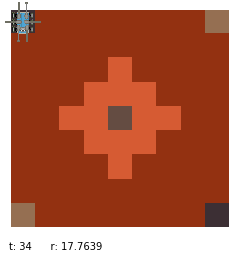

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


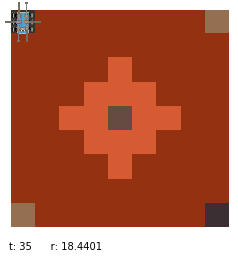

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


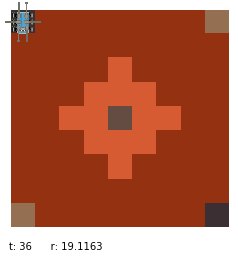

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


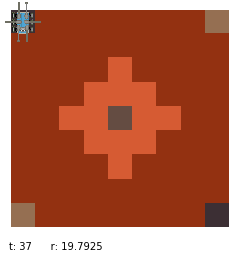

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


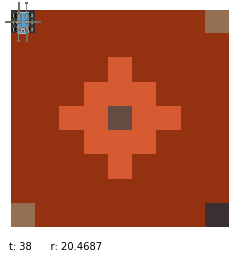

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


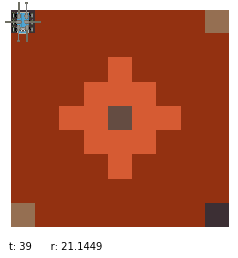

[66.21082989 65.49103757 65.17481061 65.81143797 67.61876206]
4
[0.15151653 0.07376633 0.05376784 0.10162634 0.61932296]
(0, 0) b'2'
(0, 0) b'2'


In [80]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [81]:
print(demo_stats(mdp, IDL_trans_demos))

{'mean episode reward': 11.882286132462806, 'sd episode reward': 10.613146933018852, 'mean discounted episode reward': 9.540301079787401, 'sd discounted episode reward': 8.472958386557611}


In [82]:
print(demo_stats(mdp, SERD_trans_demos))

{'mean episode reward': 16.397288065671972, 'sd episode reward': 5.05682339145125, 'mean discounted episode reward': 13.132312860578265, 'sd discounted episode reward': 4.149404578780691}


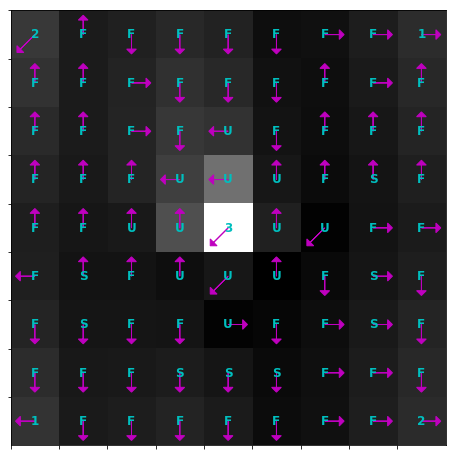

In [83]:
plot_values(mdp, Qit)

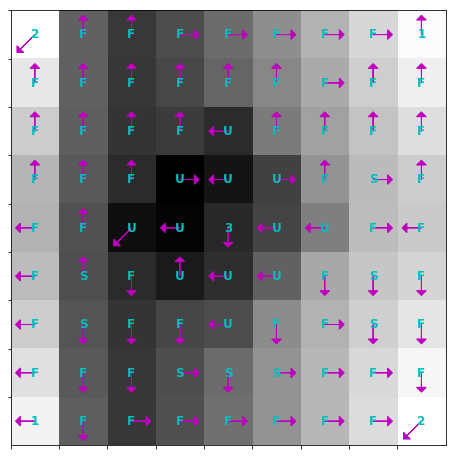

In [84]:
plot_values(mdp, Qst)

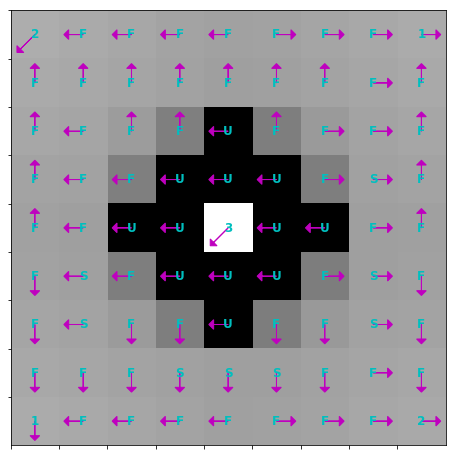

In [85]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)